# Coleta do dataset
Aproveitando a matéria de RPA, vamos efetuar a coleta de dados via webscraping.
Vamos gerar um dataset de riscos de queimadas e incêndios dos últimos 30 dias do site: https://terrabrasilis.dpi.inpe.br/queimadas/portal/dados-abertos/

In [1]:
!python --version

Python 3.11.13


In [52]:
!pip install requests
!pip install beautifulsoup4
!pip install --force-reinstall pandas==2.2.0
!pip install numba==0.60.0
!pip install pycaret==3.3.2

  Using cached pandas-2.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstal

  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 80, in main
    return command.main(cmd_args)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 100, in main
    return self._main(args)
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 234, in _main
    self.handle_pip_version_check(options)
  File "/usr/local/lib

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime
from bs4 import BeautifulSoup

from pycaret.classification import *

In [3]:
# Setando url
url = "https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/diario/Brasil/"

# Requisição da página
response = requests.get(url)
response.raise_for_status()  # Gera erro caso a requisição falhe

# Parseando o HTML com BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')
# soup

# Recuperando todas as urls dos arquivos diários

table = soup.find_all('div', class_='row') # recuperando os registro diários
table.pop(0) # removendo heade

base_url = "https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/diario/Brasil/"

dados = pd.DataFrame(columns=['titulo', 'tamanho', 'data', 'link'])

for row in table:
    titulo, tamanho, _ = row.find_all('div', class_='cell')

    link_tag = row.find('a')
    if link_tag and 'href' in link_tag.attrs:
        href = link_tag['href']
        titulo =  titulo.text.replace('\n', '')
        tamanho = tamanho.text
        data_titulo = titulo.split('_')[-1].split('.')[0]
        data = datetime.strptime(data_titulo, "%Y%m%d")

        nova_linha = pd.DataFrame([{
          'titulo': titulo,
          'tamanho': tamanho,
          'data': data,
          'link': base_url + href
        }])

        # Concatenando a nova linha ao DataFrame 'dados'
        if not nova_linha.dropna(how='all').empty:
            dados = pd.concat([dados, nova_linha], ignore_index=True)

        dados.to_csv('./links.csv', index=False)

relatorio = pd.DataFrame()
for index, row in dados.iterrows():
    df = pd.read_csv(row['link'])
    relatorio = pd.concat([relatorio, df], ignore_index=True)

relatorio.to_csv('./dados.csv', index=False)
print('Arquivo salvo em ./dados.csv')

Arquivo salvo em ./dados.csv


# Análise exploratória

## Primeiras 5 linhas do dataframe

In [4]:
df = pd.read_csv('./dados.csv')
df.head()

,id,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp
0,96d7fd91-378f-3304-a9a6-9ddad22a6caf,-19.8114,-47.8321,2025-05-06 00:00:00,GOES-19,UBERABA,MINAS GERAIS,Brasil,3170107,31,33,8.0,0.0,0.68,Cerrado,57.4
1,f4e70094-0243-343b-b6d0-def6f50c38d0,-14.2257,-45.4571,2025-05-06 00:00:00,GOES-19,JABORANDI,BAHIA,Brasil,2917359,29,33,6.0,0.0,0.73,Cerrado,90.0
2,b790e393-7948-3423-ad01-e59964c70efc,-21.3587,-48.6365,2025-05-06 00:00:00,GOES-19,CÂNDIDO RODRIGUES,SÃO PAULO,Brasil,3510104,35,33,8.0,0.0,0.86,Mata Atlântica,73.5
3,18cda6d2-c30a-39e9-8eeb-8538156134fc,-19.8114,-47.8321,2025-05-06 00:10:00,GOES-19,UBERABA,MINAS GERAIS,Brasil,3170107,31,33,8.0,0.0,0.68,Cerrado,55.0
4,f240bc4f-dea8-3951-8c49-d2b6928af6d3,-14.2257,-45.4571,2025-05-06 00:10:00,GOES-19,JABORANDI,BAHIA,Brasil,2917359,29,33,6.0,0.0,0.73,Cerrado,89.3


## Removendo colunas desnecessárias

In [5]:
# Remover colunas desnecessárias
drop_cols = ['id', 'lat', 'lon', 'municipio_id', 'estado_id', 'pais_id', 'pais']
df = df.drop(columns=drop_cols, errors='ignore')

## Separando data e hora

In [6]:
# separando data e hora dos registros
#df['data'] = pd.to_datetime(df['data_hora_gmt']).dt.date
#df['hora'] = pd.to_datetime(df['data_hora_gmt']).dt.time
df = df.drop('data_hora_gmt', axis=1)

## Informações gerais do dataframe

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120119 entries, 0 to 120118
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   satelite               120119 non-null  object 
 1   municipio              120119 non-null  object 
 2   estado                 120119 non-null  object 
 3   numero_dias_sem_chuva  115690 non-null  float64
 4   precipitacao           115690 non-null  float64
 5   risco_fogo             115690 non-null  float64
 6   bioma                  120118 non-null  object 
 7   frp                    117418 non-null  float64
dtypes: float64(4), object(4)
memory usage: 7.3+ MB


## Estatísticas descritivas (colunas numéricas)

In [8]:
df.describe()

,numero_dias_sem_chuva,precipitacao,risco_fogo,frp
count,115690.000000,115690.000000,115690.000000,117418.000000
mean,8.481433,0.188097,-10.883617,28.646418
std,71.371499,1.646130,106.925760,53.149934
min,-999.000000,0.000000,-999.000000,0.000000
25%,6.000000,0.000000,0.360000,3.100000
50%,13.000000,0.000000,0.800000,7.400000
75%,19.000000,0.000000,1.000000,27.100000
max,45.000000,90.460000,1.000000,1614.500000


## Contagem de valores ausentes por colunas

In [9]:
# Contagem de valores ausentes por coluna
teste = df.isnull().sum().reset_index()
teste.columns = ['colunas', 'valores ausentes']
teste

,colunas,valores ausentes
0,satelite,0
1,municipio,0
2,estado,0
3,numero_dias_sem_chuva,4429
4,precipitacao,4429
5,risco_fogo,4429
6,bioma,1
7,frp,2701


## Calculando porcentagem de registros com colunas nulas

In [10]:
total_registros = len(df)
registros_colunas_nulas = df.isnull().any(axis=1).sum()
porcentagem_colunas_nulas = (registros_colunas_nulas / total_registros) * 100

print(porcentagem_colunas_nulas)

5.936612858914909


In [11]:
df.dropna(inplace=True)

## Removendo outliers

In [12]:
mask = df['numero_dias_sem_chuva'] == -999
df.drop(index=df[mask].index, inplace=True)

mask = df['risco_fogo'] == -999
df.drop(index=df[mask].index, inplace=True)

## Definidno faixas de classificação

In [13]:
bins = [0.0, 0.33, 0.66, 1.0]
labels = ['baixo', 'medio', 'alto']

df['risco_fogo_cat'] = pd.cut(
    df['risco_fogo'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

display(df.head())

,satelite,municipio,estado,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp,risco_fogo_cat
0,GOES-19,UBERABA,MINAS GERAIS,8.0,0.0,0.68,Cerrado,57.4,alto
1,GOES-19,JABORANDI,BAHIA,6.0,0.0,0.73,Cerrado,90.0,alto
2,GOES-19,CÂNDIDO RODRIGUES,SÃO PAULO,8.0,0.0,0.86,Mata Atlântica,73.5,alto
3,GOES-19,UBERABA,MINAS GERAIS,8.0,0.0,0.68,Cerrado,55.0,alto
4,GOES-19,JABORANDI,BAHIA,6.0,0.0,0.73,Cerrado,89.3,alto


In [14]:
df.describe()

,numero_dias_sem_chuva,precipitacao,risco_fogo,frp
count,111154.000000,111154.000000,111154.000000,111154.000000
mean,13.496797,0.178901,0.687828,29.082536
std,8.282695,1.574508,0.330875,53.819406
min,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.380000,3.100000
50%,13.000000,0.000000,0.820000,7.500000
75%,19.000000,0.000000,1.000000,27.900000
max,45.000000,90.460000,1.000000,1614.500000


In [15]:
df.head()

,satelite,municipio,estado,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp,risco_fogo_cat
0,GOES-19,UBERABA,MINAS GERAIS,8.0,0.0,0.68,Cerrado,57.4,alto
1,GOES-19,JABORANDI,BAHIA,6.0,0.0,0.73,Cerrado,90.0,alto
2,GOES-19,CÂNDIDO RODRIGUES,SÃO PAULO,8.0,0.0,0.86,Mata Atlântica,73.5,alto
3,GOES-19,UBERABA,MINAS GERAIS,8.0,0.0,0.68,Cerrado,55.0,alto
4,GOES-19,JABORANDI,BAHIA,6.0,0.0,0.73,Cerrado,89.3,alto


## Colunas numéricas e categóricas

In [16]:
colunas_numericas = df.select_dtypes(include=['number']).columns.tolist()
colunas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nColunas numéricas: {colunas_numericas}")
print(f"Colunas categóricas: {colunas_categoricas}")


Colunas numéricas: ['numero_dias_sem_chuva', 'precipitacao', 'risco_fogo', 'frp']
Colunas categóricas: ['satelite', 'municipio', 'estado', 'bioma', 'risco_fogo_cat']


## Histograma das colunas numéricas

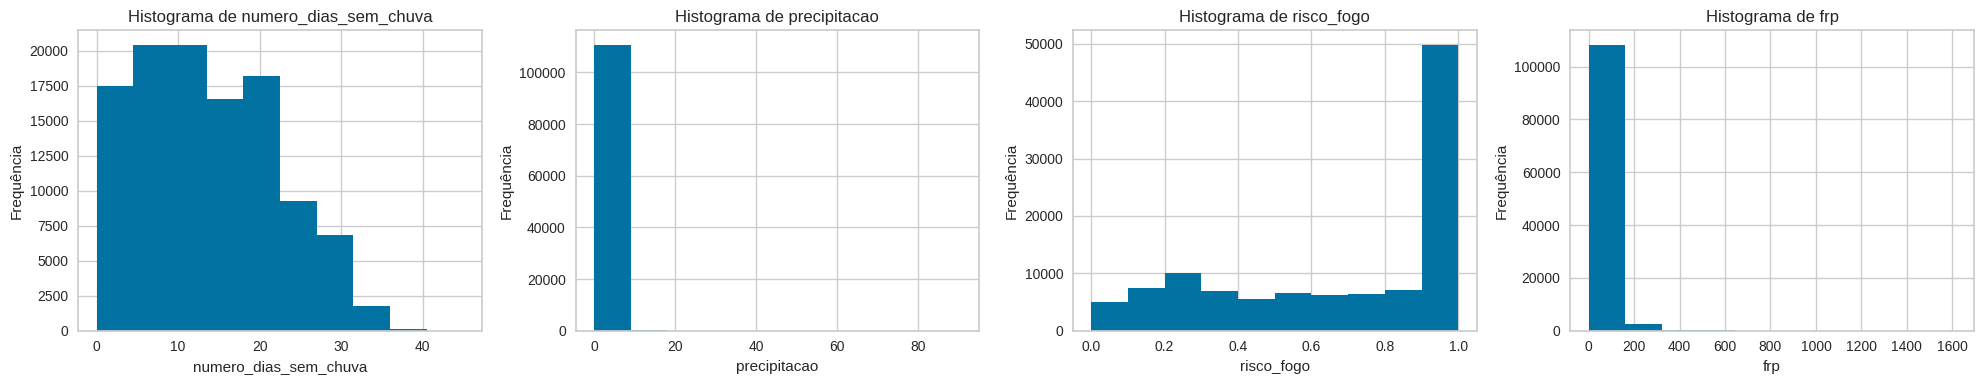

In [17]:
  n_cols = 4
  n_rows = (len(colunas_numericas) + n_cols - 1) // n_cols

  plt.figure(figsize=(20, n_rows * 4))

  for i, col in enumerate(colunas_numericas):
      plt.subplot(n_rows, n_cols, i + 1)
      df[col].hist()
      plt.title(f'Histograma de {col}')
      plt.xlabel(col)
      plt.ylabel('Frequência')

  plt.tight_layout()
  plt.show()

## Histograma de queimadas por número de dias sem chuva:

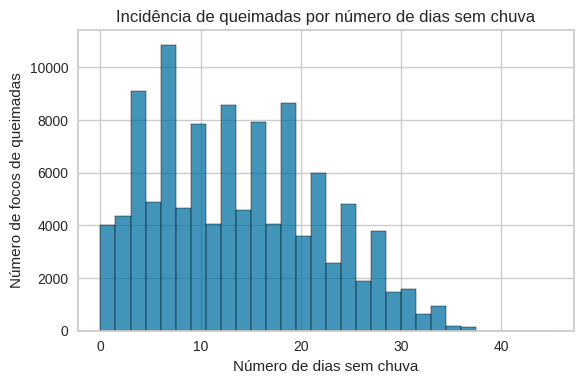

In [18]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='numero_dias_sem_chuva', bins=30, kde=False)
plt.title('Incidência de queimadas por número de dias sem chuva')
plt.xlabel('Número de dias sem chuva')
plt.ylabel('Número de focos de queimadas')
plt.tight_layout()
plt.show()

## Histograma de incidência de queimadas por FRP (fire radiation power)

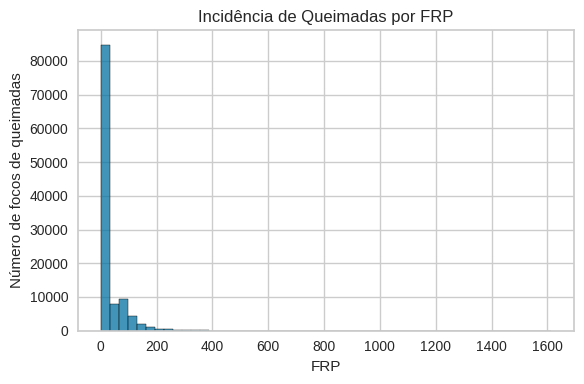

In [19]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='frp', bins=50, kde=False)
plt.title('Incidência de Queimadas por FRP')
plt.xlabel('FRP')
plt.ylabel('Número de focos de queimadas')
plt.tight_layout()
plt.show()

## Matriz de correlação

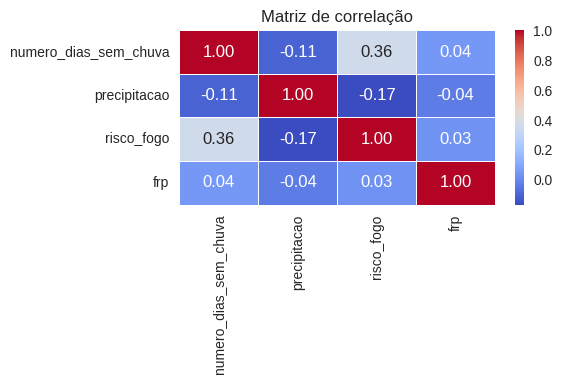

In [20]:
if len(colunas_numericas) > 1:
    corr = df[colunas_numericas].corr()
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matriz de correlação')
    plt.tight_layout()
    plt.show()

## Top 10 estados com maior incidência de queimadas por Bioma

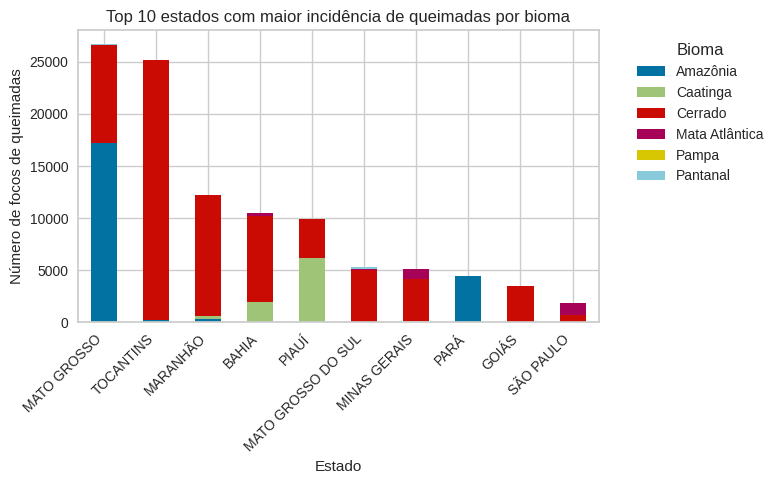

In [21]:
incidencia_estado_bioma = df.groupby(['estado', 'bioma']).size().unstack(fill_value=0)

total_incidencia_por_estado = incidencia_estado_bioma.sum(axis=1).sort_values(ascending=False)
top_10_estados = total_incidencia_por_estado.head(10).index.tolist()

incidencia_estado_bioma_top_10 = incidencia_estado_bioma.loc[top_10_estados]

incidencia_estado_bioma_top_10.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Top 10 estados com maior incidência de queimadas por bioma')
plt.xlabel('Estado')
plt.ylabel('Número de focos de queimadas')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Bioma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Top 10 estados com maior FRP (fire radiation power)

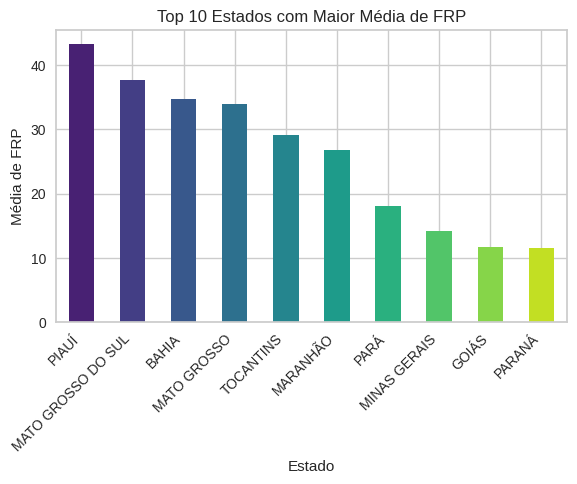

In [22]:
average_frp_por_estado = df.groupby('estado')['frp'].mean().sort_values(ascending=False)
top_10_estados_frp = average_frp_por_estado.head(10)

plt.figure(figsize=(6, 5))
top_10_estados_frp.plot(kind='bar', color=sns.color_palette('viridis', len(top_10_estados_frp)))
plt.title('Top 10 Estados com Maior Média de FRP')
plt.xlabel('Estado')
plt.ylabel('Média de FRP')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Média de dias sem chuva por estado

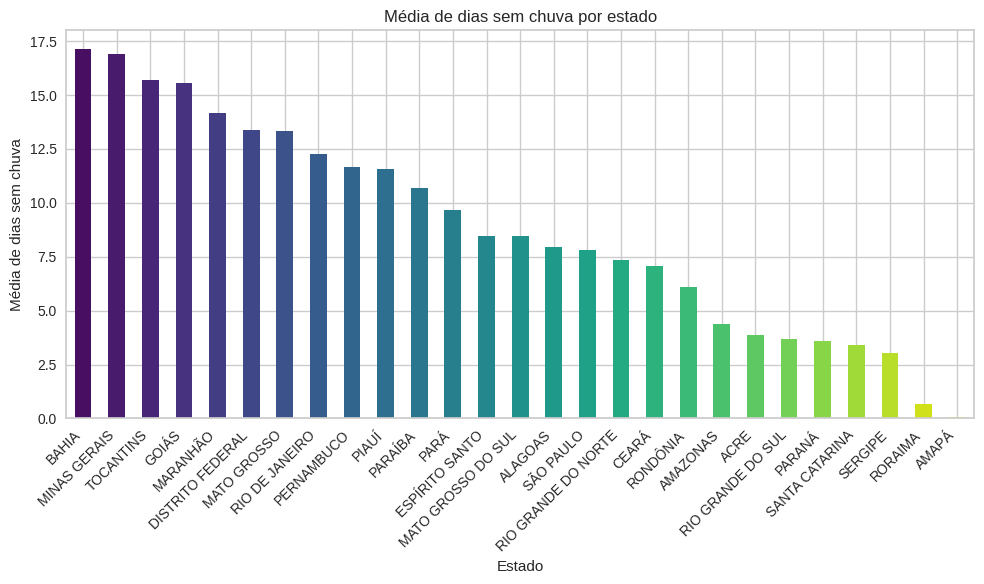

In [23]:
average_dias_sem_chuva_por_estado = df.groupby('estado')['numero_dias_sem_chuva'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
average_dias_sem_chuva_por_estado.plot(kind='bar', color=sns.color_palette('viridis', len(average_dias_sem_chuva_por_estado)))
plt.title('Média de dias sem chuva por estado')
plt.xlabel('Estado')
plt.ylabel('Média de dias sem chuva')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Modelagem - Machine Learning

## Train Test Validation Split

In [24]:
df = df.drop(columns=['risco_fogo'], errors='ignore')

# sample 5% of data to be used as unseen data
df_train_test = df.sample(frac=0.95, random_state=123)
df_valid = df.drop(df_train_test.index)
df_train_test.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)
# print the revised shape
print('Data for Modeling: ' + str(df_train_test.shape))
print('Unseen Data For Predictions: ' + str(df_valid.shape))

Data for Modeling: (105596, 8)
Unseen Data For Predictions: (5558, 8)


## Setup

In [25]:
s = setup(data = df_train_test,
          target = 'risco_fogo_cat',
          fix_imbalance = True,
          remove_outliers = True,
          categorical_features = ['bioma', 'estado', 'municipio', 'satelite'],
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,risco_fogo_cat
2,Target type,Multiclass
3,Target mapping,"alto: 0, baixo: 1, medio: 2"
4,Original data shape,"(105596, 8)"
5,Transformed data shape,"(158198, 21)"
6,Transformed train set shape,"(126519, 21)"
7,Transformed test set shape,"(31679, 21)"
8,Numeric features,3
9,Categorical features,4


In [26]:
models = compare_models(exclude=['lightgbm'],) #por algum motivo o lgbm estava trabando o processo no macbook

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8441,0.9512,0.8441,0.8450,0.8443,0.7262,0.7264,3.0660
et,Extra Trees Classifier,0.8406,0.9382,0.8406,0.8405,0.8404,0.7191,0.7192,3.0210
dt,Decision Tree Classifier,0.8284,0.8661,0.8284,0.8308,0.8295,0.6987,0.6988,0.6320
xgboost,Extreme Gradient Boosting,0.8190,0.9446,0.8190,0.8262,0.8216,0.6872,0.6884,1.7290
gbc,Gradient Boosting Classifier,0.7734,0.0000,0.7734,0.7931,0.7801,0.6162,0.6199,8.0650
ada,Ada Boost Classifier,0.7457,0.0000,0.7457,0.7709,0.7544,0.5717,0.5760,1.4470
ridge,Ridge Classifier,0.7256,0.0000,0.7256,0.7497,0.7350,0.5348,0.5377,0.5160
lr,Logistic Regression,0.7204,0.0000,0.7204,0.7499,0.7318,0.5288,0.5325,3.8600
lda,Linear Discriminant Analysis,0.7103,0.0000,0.7103,0.7512,0.7250,0.5184,0.5245,0.5500
svm,SVM - Linear Kernel,0.6986,0.0000,0.6986,0.7374,0.7047,0.4940,0.5060,1.8250


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

## Análise dos modelos

In [27]:
evaluate_model(models)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Tunning dos 3 melhores modelos

In [28]:
mdl_rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8459,0.9531,0.8459,0.8471,0.8463,0.7295,0.7297
1,0.8410,0.9504,0.8410,0.8420,0.8415,0.7205,0.7206
2,0.8492,0.9526,0.8492,0.8489,0.8487,0.7344,0.7347
3,0.8467,0.9536,0.8467,0.8492,0.8477,0.7318,0.7321
4,0.8428,0.9511,0.8428,0.8434,0.8429,0.7238,0.7239
5,0.8474,0.9526,0.8474,0.8489,0.8480,0.7326,0.7328
6,0.8424,0.9493,0.8424,0.8430,0.8425,0.7230,0.7232
7,0.8397,0.9503,0.8397,0.8414,0.8401,0.7195,0.7199
8,0.8391,0.9488,0.8391,0.8395,0.8389,0.7172,0.7176


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
tuned_rf = tune_model(mdl_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7541,0.9045,0.7541,0.7852,0.7637,0.5900,0.5966
1,0.7524,0.9040,0.7524,0.7824,0.7632,0.5841,0.5891
2,0.7688,0.9089,0.7688,0.7952,0.7773,0.6123,0.6177
3,0.7631,0.9050,0.7631,0.7893,0.7727,0.6004,0.6045
4,0.7573,0.9078,0.7573,0.7950,0.7694,0.5977,0.6055
5,0.7514,0.9026,0.7514,0.7819,0.7608,0.5853,0.5918
6,0.7465,0.9020,0.7465,0.7817,0.7573,0.5795,0.5869
7,0.7489,0.9019,0.7489,0.7850,0.7605,0.5833,0.5906
8,0.7533,0.8997,0.7533,0.7861,0.7641,0.5889,0.5953


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
mdl_et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8435,0.9401,0.8435,0.8441,0.8437,0.7247,0.7248
1,0.8364,0.9367,0.8364,0.8356,0.8360,0.7106,0.7106
2,0.8451,0.9405,0.8451,0.8442,0.8445,0.7266,0.7267
3,0.8431,0.9410,0.8431,0.8444,0.8437,0.7243,0.7244
4,0.8392,0.9359,0.8392,0.8386,0.8387,0.7163,0.7164
5,0.8436,0.9377,0.8436,0.8444,0.8439,0.7251,0.7252
6,0.8381,0.9389,0.8381,0.8379,0.8378,0.7148,0.7149
7,0.8420,0.9380,0.8420,0.8428,0.8421,0.7226,0.7228
8,0.8341,0.9356,0.8341,0.8332,0.8335,0.7071,0.7072


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [31]:
tuned_et = tune_model(mdl_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7541,0.9045,0.7541,0.7852,0.7637,0.5900,0.5966
1,0.7524,0.9040,0.7524,0.7824,0.7632,0.5841,0.5891
2,0.7688,0.9089,0.7688,0.7952,0.7773,0.6123,0.6177
3,0.7631,0.9050,0.7631,0.7893,0.7727,0.6004,0.6045
4,0.7573,0.9078,0.7573,0.7950,0.7694,0.5977,0.6055
5,0.7514,0.9026,0.7514,0.7819,0.7608,0.5853,0.5918
6,0.7465,0.9020,0.7465,0.7817,0.7573,0.5795,0.5869
7,0.7489,0.9019,0.7489,0.7850,0.7605,0.5833,0.5906
8,0.7533,0.8997,0.7533,0.7861,0.7641,0.5889,0.5953


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [32]:
mdl_dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8271,0.8646,0.8271,0.8292,0.8281,0.6961,0.6962
1,0.8244,0.8629,0.8244,0.8262,0.8252,0.6910,0.6911
2,0.8295,0.8666,0.8295,0.8317,0.8305,0.7007,0.7008
3,0.8331,0.8720,0.8331,0.8362,0.8345,0.7074,0.7076
4,0.8268,0.8668,0.8268,0.8305,0.8285,0.6969,0.6971
5,0.8309,0.8671,0.8309,0.8333,0.8320,0.7031,0.7032
6,0.8290,0.8658,0.8290,0.8311,0.8300,0.6997,0.6998
7,0.8306,0.8690,0.8306,0.8342,0.8322,0.7037,0.7040
8,0.8221,0.8616,0.8221,0.8246,0.8233,0.6881,0.6882


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
tuned_dt = tune_model(mdl_dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7542,0.9037,0.7542,0.7853,0.7638,0.5902,0.5968
1,0.7522,0.9033,0.7522,0.7823,0.7630,0.5838,0.5888
2,0.7683,0.9071,0.7683,0.7950,0.7769,0.6116,0.6171
3,0.7633,0.9035,0.7633,0.7898,0.7729,0.6008,0.6051
4,0.7572,0.9071,0.7572,0.7949,0.7692,0.5975,0.6053
5,0.7514,0.9003,0.7514,0.7820,0.7609,0.5854,0.5918
6,0.7459,0.9001,0.7459,0.7816,0.7569,0.5788,0.5863
7,0.7487,0.9015,0.7487,0.7852,0.7605,0.5832,0.5906
8,0.7533,0.8983,0.7533,0.7861,0.7641,0.5889,0.5953


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


# Exportando melhor modelo

In [34]:
save_model(mdl_rf, './pickle_rf_pycaret')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['numero_dias_sem_chuva',
                                              'precipitacao', 'frp'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=Fa...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_f

In [35]:
cols_x_test = get_config(variable="X_test").columns
cols_x_test

Index(['satelite', 'municipio', 'estado', 'numero_dias_sem_chuva',
       'precipitacao', 'bioma', 'frp'],
      dtype='object')

In [36]:
df_valid.drop('risco_fogo_cat', axis = 1).to_csv('Xtest.csv', index = False)
df_valid

,satelite,municipio,estado,numero_dias_sem_chuva,precipitacao,bioma,frp,risco_fogo_cat
0,TERRA_M-M,CÂNDIDO RODRIGUES,SÃO PAULO,8.0,0.0,Cerrado,39.9,alto
1,TERRA_M-M,JABORANDI,BAHIA,6.0,0.0,Cerrado,23.8,alto
2,TERRA_M-M,BALSAS,MARANHÃO,5.0,0.0,Cerrado,7.6,alto
3,GOES-19,JABORANDI,BAHIA,6.0,0.0,Cerrado,70.0,alto
4,GOES-19,JABORANDI,BAHIA,6.0,0.0,Cerrado,70.8,alto
...,...,...,...,...,...,...,...,...
5553,GOES-19,LAGOA DO MATO,MARANHÃO,28.0,0.0,Cerrado,125.8,alto
5554,GOES-19,BRASNORTE,MATO GROSSO,6.0,0.0,Cerrado,94.3,baixo
5555,GOES-19,GOIATINS,TOCANTINS,24.0,0.0,Cerrado,47.0,alto
5556,GOES-19,GOIATINS,TOCANTINS,21.0,0.0,Cerrado,34.2,alto
